# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [40]:
import pandas as pd
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [41]:
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [50]:
# preproc1
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
category_features = ['month', 'day']

preproc1 = ColumnTransformer(transformers=[('num_transforms', StandardScaler(), numeric_features), ('cat_transforms', OneHotEncoder(handle_unknown='ignore'), category_features)])
preproc1

ColumnTransformer(transformers=[('num_transforms', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

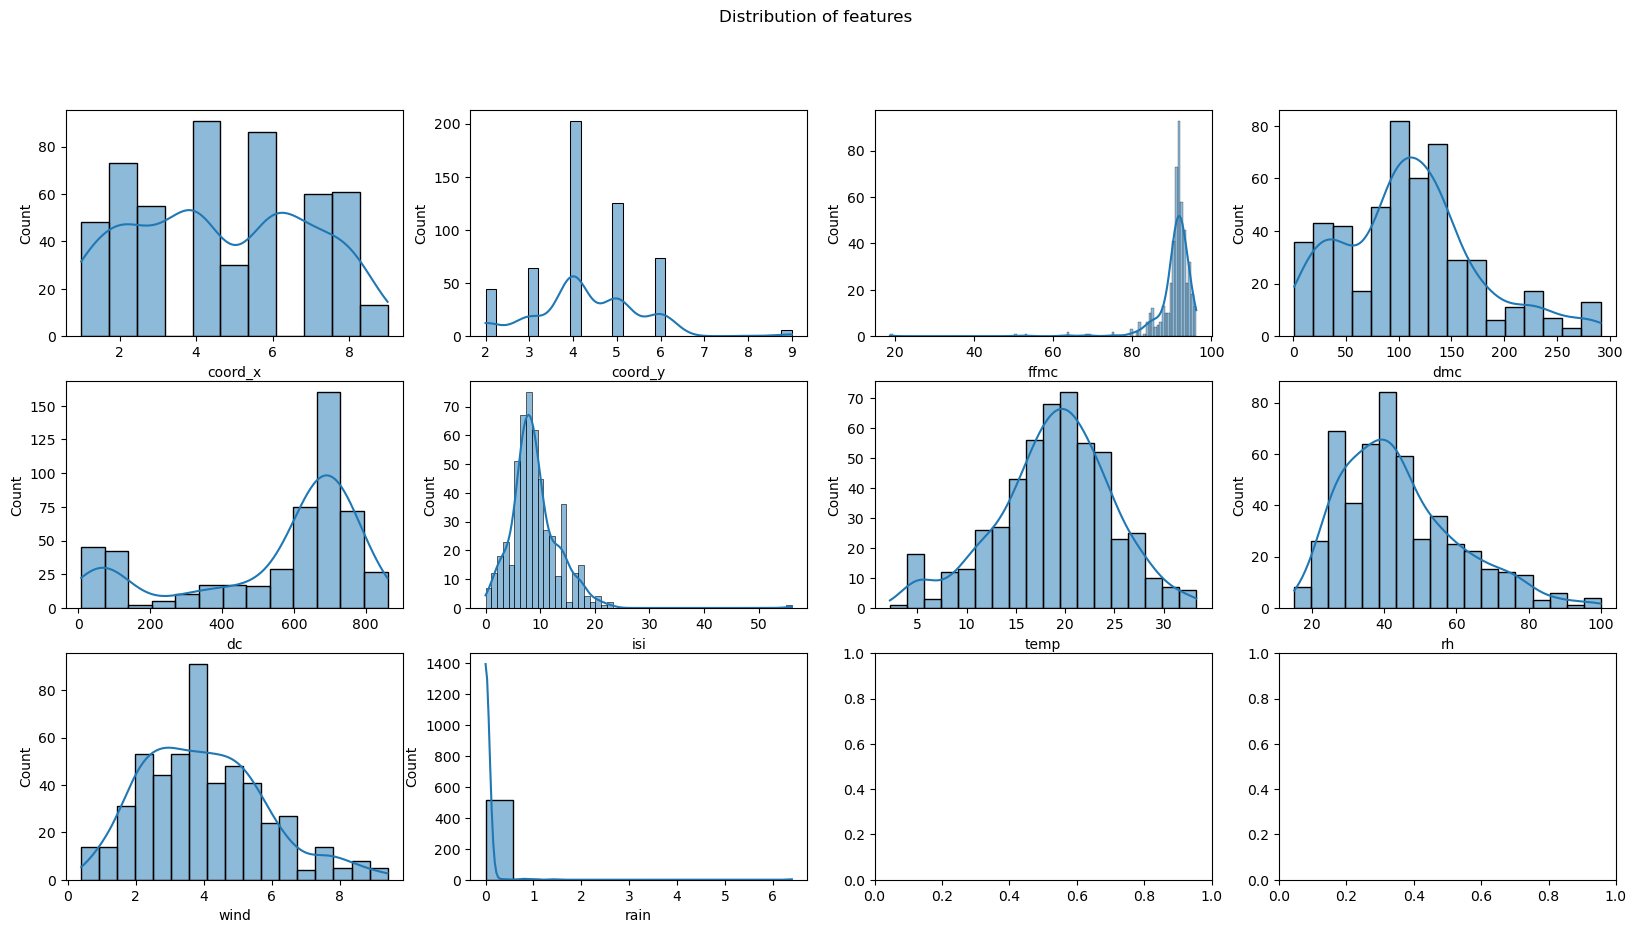

In [51]:
# Analyzing distribution of each feature to decide if we need to apply a transformation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle('Distribution of features')
for i, feature in enumerate(numeric_features):
    sns.histplot(X[feature], ax=axes[i//4, i%4], kde=True)
plt.show()


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [58]:
# preproc2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

non_linear_transforms = ColumnTransformer(transformers=[('quantile_transform', QuantileTransformer(n_quantiles=10), ['rain']), ('power_transform', PowerTransformer(), ['ffmc'])], remainder='passthrough')

numeric_pipeline = Pipeline(steps=[('non_linear_transforms', non_linear_transforms), ('standard_scaler', StandardScaler())])
categorical_pipeline = Pipeline(steps=[('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])
preproc2 = ColumnTransformer(transformers=[('num_transforms', numeric_pipeline, numeric_features), ('cat_transforms', categorical_pipeline, category_features)])
preproc2

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('non_linear_transforms',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('quantile_transform',
                                                                                   QuantileTransformer(n_quantiles=10),
                                                                                   ['rain']),
                                                                                  ('power_transform',
                                                                                   PowerTransformer(),
                                                                                   ['ffmc'])])),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [54]:
# Pipeline A = preproc1 + baseline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

pipeline_A = Pipeline(steps=[('preprocessor', preproc1), ('regressor', LinearRegression())])
cv_results_A = cross_validate(pipeline_A, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
cv_results_A

{'fit_time': array([0.05256391, 0.01914692, 0.01111579, 0.01392317, 0.01655602]),
 'score_time': array([0.00258517, 0.00354099, 0.00426412, 0.00346279, 0.00320411]),
 'test_score': array([  -757.95493915,   -455.264036  , -13472.63483258,   -669.81264013,
         -6793.33486457]),
 'train_score': array([-4699.21965533, -4749.46420594, -1672.27438733, -4675.13705883,
        -3224.74920889])}

In [59]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline(steps=[('preprocessor', preproc2), ('regressor', LinearRegression())])
cv_results_B = cross_validate(pipeline_B, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
cv_results_B

{'fit_time': array([0.02932692, 0.0113399 , 0.01734686, 0.00609398, 0.00853586]),
 'score_time': array([0.00634098, 0.00283813, 0.00259089, 0.00385213, 0.00461912]),
 'test_score': array([  -762.16172923,   -465.99224059, -13489.23906401,   -659.95590549,
         -6811.12853436]),
 'train_score': array([-4698.10044237, -4747.95517767, -1670.15292939, -4674.26437039,
        -3223.19668344])}

In [61]:
# Pipeline C = preproc1 + advanced model
from sklearn.ensemble import RandomForestRegressor
pipeline_C = Pipeline(steps=[('preprocessor', preproc1), ('regressor', RandomForestRegressor())])
cv_results_C = cross_validate(pipeline_C, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
cv_results_C

{'fit_time': array([0.20744872, 0.17260194, 0.18532991, 0.17661595, 0.17446303]),
 'score_time': array([0.00453305, 0.0039351 , 0.00411487, 0.00424194, 0.00397491]),
 'test_score': array([ -2145.92220867,   -512.38468804, -13608.906061  ,  -1108.10326009,
         -6966.20387101]),
 'train_score': array([-672.87152705, -784.81351233, -330.69981036, -781.04543482,
        -482.92027337])}

In [62]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline(steps=[('preprocessor', preproc2), ('regressor', RandomForestRegressor())])
cv_results_D = cross_validate(pipeline_D, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
cv_results_D

{'fit_time': array([0.20669699, 0.17139721, 0.17919493, 0.17384505, 0.16994715]),
 'score_time': array([0.00562906, 0.00499678, 0.00523901, 0.00601101, 0.00569701]),
 'test_score': array([ -1906.17967378,   -673.60989153, -13678.19719191,   -779.14169323,
         -6959.28155014]),
 'train_score': array([ -948.36942698,  -757.32572996,  -346.07419602, -1029.80628012,
         -527.62174684])}

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid_A = {
    'preprocessor__num_transforms__with_mean': [True, False],
    'preprocessor__num_transforms__with_std': [True, False],
    'regressor__fit_intercept': [True, False]
}

grid_search_A = GridSearchCV(pipeline_A, param_grid_A, cv=5)
grid_search_A.fit(X, y)

best_params_A = grid_search_A.best_params_
best_score_A = grid_search_A.best_score_

print("Best parameters:", best_params_A)
print("Best score:", best_score_A)

Best parameters: {'preprocessor__num_transforms__with_mean': False, 'preprocessor__num_transforms__with_std': False, 'regressor__fit_intercept': False}
Best score: -4.61739851919093


In [69]:
# Define the parameter grid
param_grid_B = {
    'preprocessor__num_transforms__non_linear_transforms__quantile_transform__n_quantiles': [5, 10, 15],
    'preprocessor__num_transforms__non_linear_transforms__power_transform__method': ['yeo-johnson', 'box-cox'],
    'regressor__fit_intercept': [True, False]
}

# Create the GridSearchCV object
grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=5)

# Fit the GridSearchCV object to the data
grid_search_B.fit(X, y)

# Get the best parameters and best score
best_params_B = grid_search_B.best_params_
best_score_B = grid_search_B.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params_B)
print("Best Score:", best_score_B)

Best Parameters: {'preprocessor__num_transforms__non_linear_transforms__power_transform__method': 'yeo-johnson', 'preprocessor__num_transforms__non_linear_transforms__quantile_transform__n_quantiles': 5, 'regressor__fit_intercept': True}
Best Score: -4.724500541079845


In [70]:
# Define the parameter grid
param_grid_C = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_split': [2, 5, 10]
}

# Create the GridSearchCV object
grid_search_C = GridSearchCV(pipeline_C, param_grid_C, cv=5)

# Fit the grid search to the data
grid_search_C.fit(X, y)

# Get the best parameters and best score
best_params_C = grid_search_C.best_params_
best_score_C = grid_search_C.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params_C)
print("Best Score:", best_score_C)

Best Parameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}
Best Score: -2.7851048384131305


In [71]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_D = {
    'preprocessor__num_transforms__non_linear_transforms__quantile_transform__n_quantiles': [5, 10, 15],
    'preprocessor__num_transforms__non_linear_transforms__power_transform__method': ['yeo-johnson', 'box-cox'],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_split': [2, 5, 10]
}

# Create the GridSearchCV object
grid_search_D = GridSearchCV(pipeline_D, param_grid_D, cv=5)

# Fit the grid search to the data
grid_search_D.fit(X, y)

# Get the best parameters and best score
best_params_D = grid_search_D.best_params_
best_score_D = grid_search_D.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params_D)
print("Best Score:", best_score_D)

Best Parameters: {'preprocessor__num_transforms__non_linear_transforms__power_transform__method': 'box-cox', 'preprocessor__num_transforms__non_linear_transforms__quantile_transform__n_quantiles': 15, 'regressor__max_depth': 5, 'regressor__min_samples_split': 10}
Best Score: -2.3577137938005164


In [117]:
cv_results_best = cross_validate(grid_search_D.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
cv_results_best

{'fit_time': array([0.12438869, 0.09635282, 0.09670687, 0.09414601, 0.09074616]),
 'score_time': array([0.00513029, 0.00458503, 0.00441909, 0.00439715, 0.00444388]),
 'test_score': array([  -883.99370158,   -284.10978982, -13580.20348104,   -935.35929269,
         -6745.39895409]),
 'train_score': array([-2421.61774221, -2281.92956195,  -821.59348768, -1953.65366469,
        -1016.5349487 ])}

# Evaluate

+ Which model has the best performance?

    Pipeline_D with following hyperparameters:

    ```Best Parameters: {'preprocessor__num_transforms__non_linear_transforms__power_transform__method': 'box-cox', 'preprocessor__num_transforms__non_linear_transforms__quantile_transform__n_quantiles': 15, 'regressor__max_depth': 5, 'regressor__min_samples_split': 10}```

    Is the best model as it's negative MSE is closest to 0.


# Export

+ Save the best performing model to a pickle file.

In [77]:
import pickle

# Specify the file path to save the pickle file
file_path = './grid_search_D.pkl'

# Save the grid_search_D object to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(grid_search_D.best_estimator_, file)

# Load the grid_search_D object from the pickle file
with open(file_path, 'rb') as file:
    grid_search_D_loaded = pickle.load(file)

grid_search_D_loaded

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('non_linear_transforms',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('quantile_transform',
                                                                                                    QuantileTransformer(n_quantiles=15),
                                                                                                    ['rain']),
                                                                                                   ('power_transform',
                                                                                                    PowerTransformer(method='box-cox'),
                                                                                                    ['ffmc'])])),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=5, min_samples_split=10))])

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

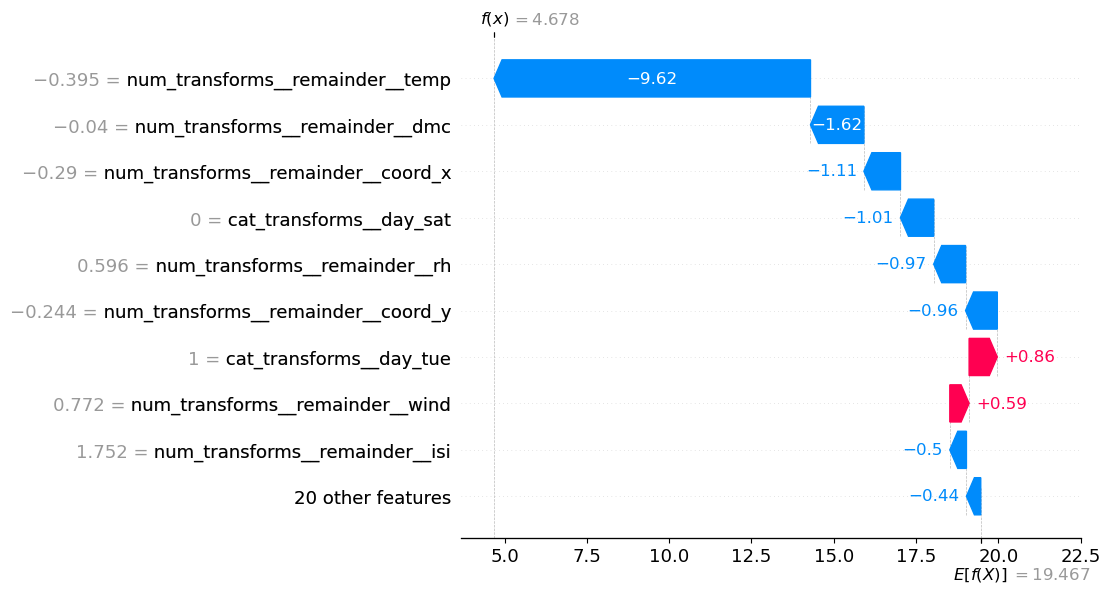

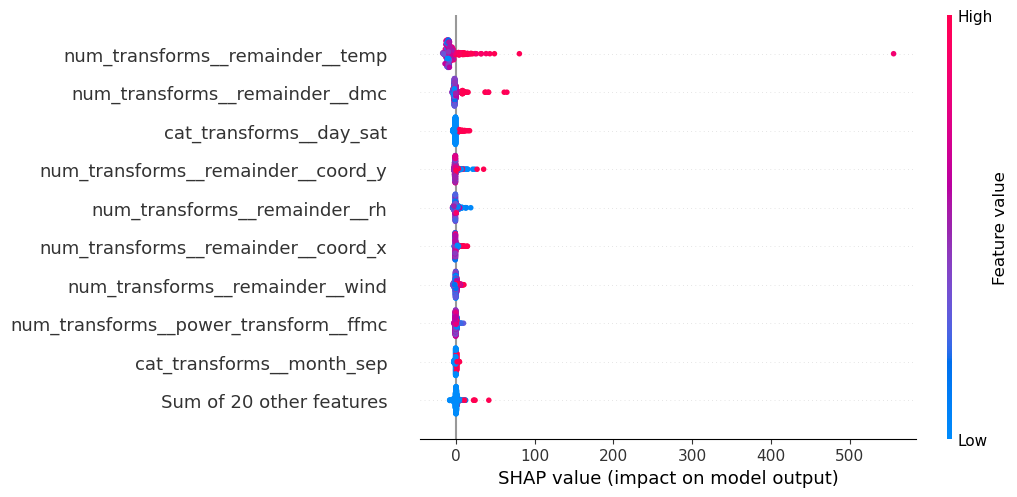

In [115]:
import shap

data_transform = grid_search_D.best_estimator_.named_steps['preprocessor'].transform(X)

# Create an explainer object using the best-performing model
explainer = shap.explainers.Tree(
    grid_search_D.best_estimator_.named_steps['regressor'],
    data_transform,
    feature_names = grid_search_D.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
)

shap_values = explainer(data_transform)
shap.plots.waterfall(shap_values[42])
shap.plots.beeswarm(shap_values)

*(Answer here.)*

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.